### This notebook 
### 1. Clusters the beached points with the HDBSCAN clustering method from scikit-learn in 3 ways:
#### a. lat/lon of beached points
#### b. lat/lon of beached points and total time to beach for each beached point's entire trajectory
#### c. lat/lon of beached points, total time to beach for each beached point's entire trajectory, and average speed along that trajectory
### 2. Plots density contours for resulting clusters
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html

In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [2]:
pip install hdbscan

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# dependencies
import pandas as pd
import scipy.interpolate as sci_int
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci_stats
import cartopy.crs as ccrs
import geopandas as gpd

from sklearn.preprocessing import MinMaxScaler
import hdbscan

In [3]:
# import undrogued data
beach = pd.read_csv('undrogued_beach.csv')
unbeach = pd.read_csv('undrogued_unbeach.csv')

In [4]:
beach['speed'] = np.sqrt(beach['ve']**2 + beach['vn']**2)

### CLUSTER COMPARISON (LAT/LON, TIME, AVG V)

In [5]:
# get features for clustering and normalize to close to scale of lat/lon with lat/lon weighted for clustering AND RUN HDBSCAN TWICE

# input feature: average velocity of trajectory
#v_avg_data = np.array(beach.groupby('id')['speed'].mean()).reshape(-1,1) # get average velocity for each trajectory
#v_avg_scaler = MinMaxScaler(feature_range=(0, 10)) # normalization scale
#v_avg_normalized = v_avg_scaler.fit_transform(v_avg_data).flatten() # normalize

# input feature: total time to beach
#first_points_input = beach.drop_duplicates(subset='id', keep='first') # get furthest points from beaching

#time_data = np.array(first_points_input['time_to_beach']).reshape(-1, 1) # get trajectory time to beach
#time_scaler = MinMaxScaler(feature_range=(0, 90)) # normalization scale
#time_normalized = time_scaler.fit_transform(time_data).flatten() # normalize

# get beach points for beach lat/lon
last_points_input = beach.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon))#, time_normalized, v_avg_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 30, # minimum number beach points in a cluster
    cluster_selection_epsilon = 6) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

#organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 100:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), beach_clusters_select.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(beach_clusters_select['id'])]

In [6]:
# NOW INPUT CLUSTERED DATA INTO NEW HDBSCAN

# input feature: average velocity of trajectory
#v_avg_data = np.array(beach_clusters.groupby('id')['speed'].mean()).reshape(-1,1) # get average velocity for each trajectory
#v_avg_scaler = MinMaxScaler(feature_range=(0, 10)) # normalization scale
#v_avg_normalized = v_avg_scaler.fit_transform(v_avg_data).flatten() # normalize

# input feature: total time to beach
#first_points_input = beach_clusters.drop_duplicates(subset='id', keep='first') # get furthest points from beaching

#time_data = np.array(first_points_input['time_to_beach']).reshape(-1, 1) # get trajectory time to beach
#time_scaler = MinMaxScaler(feature_range=(0, 90)) # normalization scale
#time_normalized = time_scaler.fit_transform(time_data).flatten() # normalize

# get beach points for beach lat/lon
last_points_input = beach_clusters.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon))#, time_normalized, v_avg_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 10, # minimum number beach points in a cluster
    cluster_selection_epsilon = 5) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

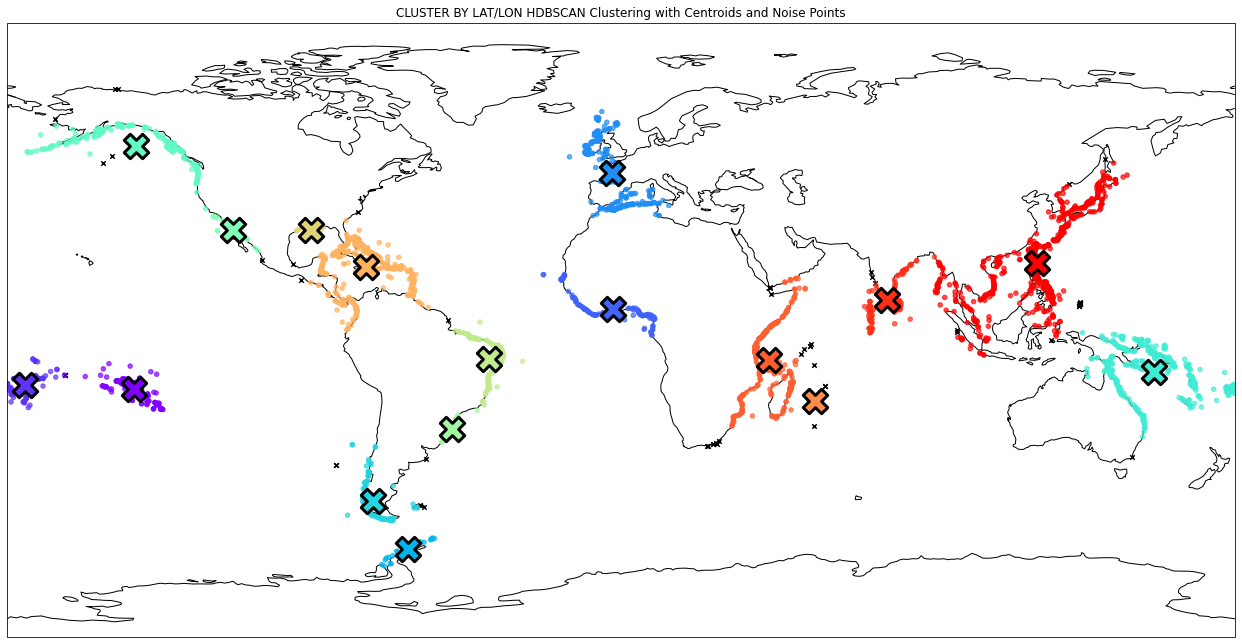

In [7]:
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

# Plot noise points as small 'x'
noise_mask = (labels == -1)
ax.scatter(cluster_input[noise_mask, 1], cluster_input[noise_mask, 0], marker='x', color='black', s=20, label='Noise Points')

# Scatter plot with colors based on HDBSCAN labels
scatter1 = plt.scatter(
    cluster_input[labels != -1, 1],
    cluster_input[labels != -1, 0],
    marker='o',
    c=labels[labels != -1],
    cmap='rainbow',
    alpha=0.7,
    s=20
)

# Plot centroids with the same colors as corresponding points
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id != -1:
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        color = scatter1.to_rgba(cluster_id)  # Get the color from the first scatter plot
        ax.scatter(centroid[1], centroid[0], marker='X', color=color, edgecolor='black', linewidths=3, s=600, label=f'Cluster {cluster_id} Centroid')

# Get the colors used in the first figure
colors_first_figure = scatter1.to_rgba(scatter1.get_array())

#ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('CLUSTER BY LAT/LON HDBSCAN Clustering with Centroids and Noise Points')
plt.show()

In [8]:
unique_labels_figure1 = np.unique(cluster_df['HDBSCAN'])

# organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 0:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# resample without replacement
num_trajectories = round(len(beach_clusters_select)/2)
resampled_df = beach_clusters_select.sample(n=num_trajectories, replace=False, random_state=42)
resampled_df.reset_index(drop=True, inplace=True)


# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), resampled_df.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(resampled_df['id'])]

# Create a colormap with distinct colors for each cluster label
colors_custom_cmap = plt.cm.get_cmap('rainbow', len(unique_labels_figure1))

# Create a dictionary to map each cluster label to its corresponding color
cluster_color_mapping = dict(zip(unique_labels_figure1, range(len(unique_labels_figure1))))

# Apply the mapping to the HDBSCAN labels in the beach_clusters DataFrame
beach_clusters['Color'] = beach_clusters['HDBSCAN'].map(cluster_color_mapping)

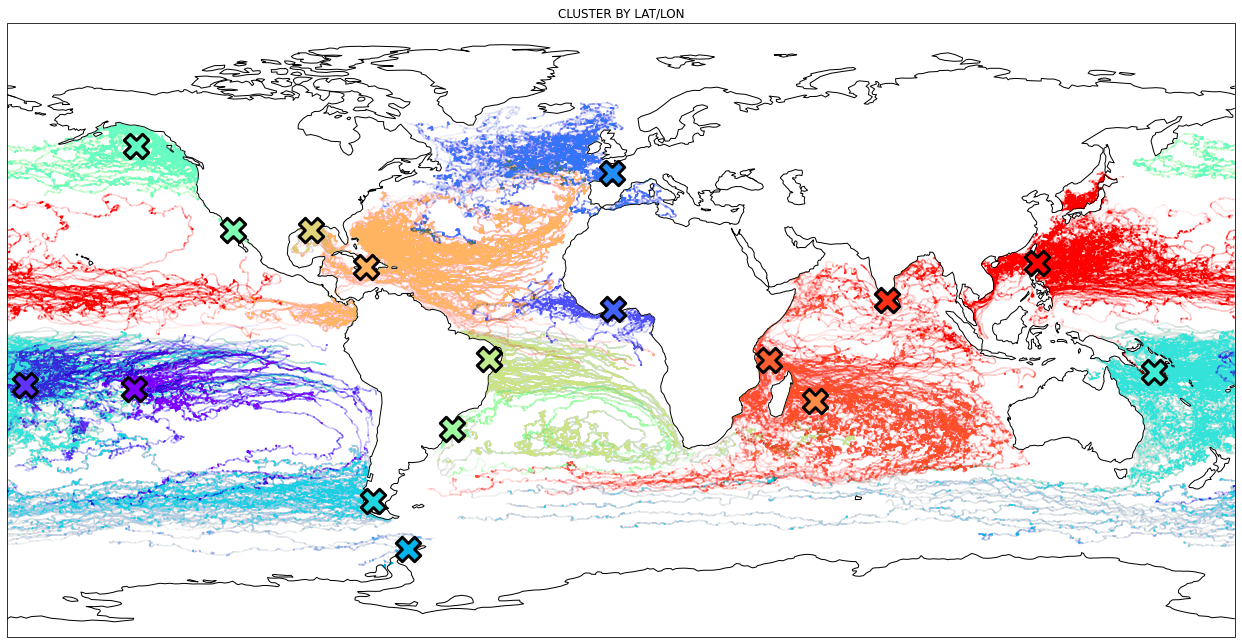

In [9]:
# Plotting code for the second figure

point_size = 0.00005

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot with colors based on the custom colormap
scatter2 = plt.scatter(
    beach_clusters['lon'],
    beach_clusters['lat'],
    marker='o',
    c=beach_clusters['Color'],
    cmap=colors_custom_cmap,
    s=point_size,
    alpha=0.7
)


# Plot centroids with the same colors as corresponding points
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id in np.unique(beach_clusters['HDBSCAN']):
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        color = scatter1.to_rgba(cluster_id)  # Get the color from the first scatter plot
        ax.scatter(centroid[1], centroid[0], marker='X', color=color, edgecolor='black', linewidths=3, s=600, label=f'Cluster {cluster_id} Centroid')


# Add colorbar
#cbar = plt.colorbar(scatter2, orientation='vertical', pad=0.02, ticks=unique_labels_figure2)
#cbar.set_label('HDBSCAN Cluster', fontsize=16)
#cbar.ax.tick_params(labelsize=14)

plt.title('CLUSTER BY LAT/LON')

plt.show()

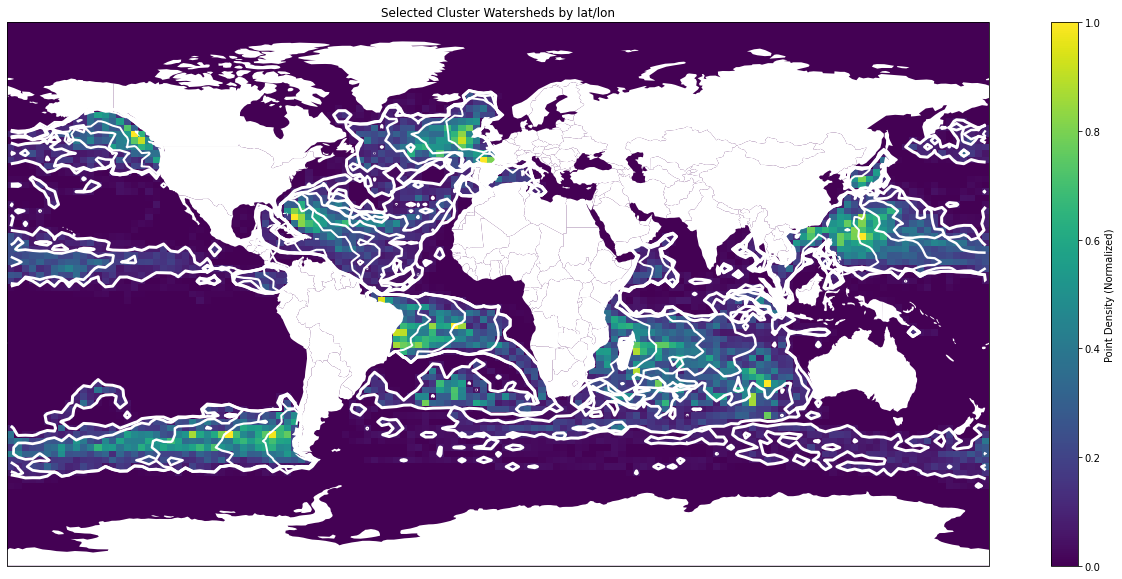

In [13]:
cluster_outputs = []
for i in np.unique(beach_clusters['HDBSCAN']):
    cluster_outputs.append(beach_clusters[beach_clusters['HDBSCAN'] == i])

selected_clusters = [cluster_outputs[i] for i in [3, 5, 7, 10, 12, 14, 16]]

fig = plt.figure(figsize=(22, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

cmap = plt.cm.get_cmap("viridis").copy()
#cmap.set_bad('grey')



###full
# Define the grid for the heatmap
n_lons, n_lats = 135, 85  # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

# initialize mesh
heatmap_data_normalized = np.zeros((n_lats, n_lons))

for cluster in selected_clusters:
    
    latitudes = []
    longitudes = []
    latitudes12 = []
    longitudes12 = []
    latitudes6 = []
    longitudes6 = []
    latitudes3 = []
    longitudes3 = []
    latitudes1 = []
    longitudes1 = []

    for ID in np.unique(cluster['id']):
        trajectory = cluster[cluster['id'] == ID]

        latest_time = max(trajectory['time'])
        start_time = latest_time - 15552000000000 # Full
        start_time12 = latest_time - 31536000 # 12m
        start_time6 = latest_time - 15552000 # 6m
        start_time3 = latest_time - 7890000 # 3m
        start_time1 = latest_time - 2629800 # 1m

        latest_data_all = trajectory[trajectory['time'] <= latest_time]

        latest_data = latest_data_all[latest_data_all['time'] >= start_time]
        latest_data12 = latest_data_all[latest_data_all['time'] >= start_time12]
        latest_data6 = latest_data_all[latest_data_all['time'] >= start_time6]
        latest_data3 = latest_data_all[latest_data_all['time'] >= start_time3]
        latest_data1 = latest_data_all[latest_data_all['time'] >= start_time1]

        latitudes += list(latest_data['lat'])
        longitudes += list(latest_data['lon'])

        latitudes12 += list(latest_data12['lat'])
        longitudes12 += list(latest_data12['lon'])

        latitudes6 += list(latest_data6['lat'])
        longitudes6 += list(latest_data6['lon'])

        latitudes3 += list(latest_data3['lat'])
        longitudes3 += list(latest_data3['lon'])

        latitudes1 += list(latest_data1['lat'])
        longitudes1 += list(latest_data1['lon'])




    # Calculate the 2D histogram (density plot) of point density
    heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized_cluster = (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

    lon_centers_cluster = (lon_bins[1:] + lon_bins[:-1]) / 2
    lat_centers_cluster = (lat_bins[1:] + lat_bins[:-1]) / 2
    
    # append to previous clusters
    heatmap_data_normalized += (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

    
    ###12

    # Calculate the 2D histogram (density plot) of point density
    heatmap_data12, _, _ = np.histogram2d(latitudes12, longitudes12, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized12 = (heatmap_data12 - np.min(heatmap_data12)) / (np.max(heatmap_data12) - np.min(heatmap_data12))

    ###6

    # Calculate the 2D histogram (density plot) of point density
    heatmap_data6, _, _ = np.histogram2d(latitudes6, longitudes6, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized6 = (heatmap_data6 - np.min(heatmap_data6)) / (np.max(heatmap_data6) - np.min(heatmap_data6))

    ###3

    # Calculate the 2D histogram (density plot) of point density
    heatmap_data3, _, _ = np.histogram2d(latitudes3, longitudes3, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized3 = (heatmap_data3 - np.min(heatmap_data3)) / (np.max(heatmap_data3) - np.min(heatmap_data3))


    ###1

    # Calculate the 2D histogram (density plot) of point density
    heatmap_data1, _, _ = np.histogram2d(latitudes1, longitudes1, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized1 = (heatmap_data1 - np.min(heatmap_data1)) / (np.max(heatmap_data1) - np.min(heatmap_data1))


    # Repeat the process for other plots with increasing linewidth
    linewidths = [3, 2.75, 2.5, 2.25, 2]
    for data_normalized, linewidth in zip([heatmap_data_normalized_cluster, heatmap_data_normalized12, heatmap_data_normalized6, heatmap_data_normalized3, heatmap_data_normalized1], linewidths):
        # Add contour lines at the specified level (0.05 in this case)
        contour = plt.contour(lon_centers_cluster, lat_centers_cluster, data_normalized, levels=[0.05], colors='white', linestyles='solid', linewidths=linewidth, transform=ccrs.PlateCarree())
    
# Plot the filled contour for normalized heatmap
mesh = ax.pcolormesh(lon_centers_cluster, lat_centers_cluster, heatmap_data_normalized, cmap=cmap, transform=ccrs.PlateCarree())

# Plot the land polygons with white face color, no edge
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(mesh, label='Point Density (Normalized)')
ax.set_aspect('auto')
plt.title('Selected Cluster Watersheds by lat/lon')

plt.show()

# ----------

In [14]:
# get features for clustering and normalize to close to scale of lat/lon with lat/lon weighted for clustering AND RUN HDBSCAN TWICE

# input feature: average velocity of trajectory
#v_avg_data = np.array(beach.groupby('id')['speed'].mean()).reshape(-1,1) # get average velocity for each trajectory
#v_avg_scaler = MinMaxScaler(feature_range=(0, 10)) # normalization scale
#v_avg_normalized = v_avg_scaler.fit_transform(v_avg_data).flatten() # normalize

# input feature: total time to beach
first_points_input = beach.drop_duplicates(subset='id', keep='first') # get furthest points from beaching

time_data = np.array(first_points_input['time_to_beach']).reshape(-1, 1) # get trajectory time to beach
time_scaler = MinMaxScaler(feature_range=(0, 90)) # normalization scale
time_normalized = time_scaler.fit_transform(time_data).flatten() # normalize

# get beach points for beach lat/lon
last_points_input = beach.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon, time_normalized))#, v_avg_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 30, # minimum number beach points in a cluster
    cluster_selection_epsilon = 6) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

#organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 100:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), beach_clusters_select.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(beach_clusters_select['id'])]

In [15]:
# NOW INPUT CLUSTERED DATA INTO NEW HDBSCAN

# input feature: average velocity of trajectory
#v_avg_data = np.array(beach_clusters.groupby('id')['speed'].mean()).reshape(-1,1) # get average velocity for each trajectory
#v_avg_scaler = MinMaxScaler(feature_range=(0, 10)) # normalization scale
#v_avg_normalized = v_avg_scaler.fit_transform(v_avg_data).flatten() # normalize

# input feature: total time to beach
first_points_input = beach_clusters.drop_duplicates(subset='id', keep='first') # get furthest points from beaching

time_data = np.array(first_points_input['time_to_beach']).reshape(-1, 1) # get trajectory time to beach
time_scaler = MinMaxScaler(feature_range=(0, 90)) # normalization scale
time_normalized = time_scaler.fit_transform(time_data).flatten() # normalize

# get beach points for beach lat/lon
last_points_input = beach_clusters.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon, time_normalized))#, v_avg_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 10, # minimum number beach points in a cluster
    cluster_selection_epsilon = 5) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

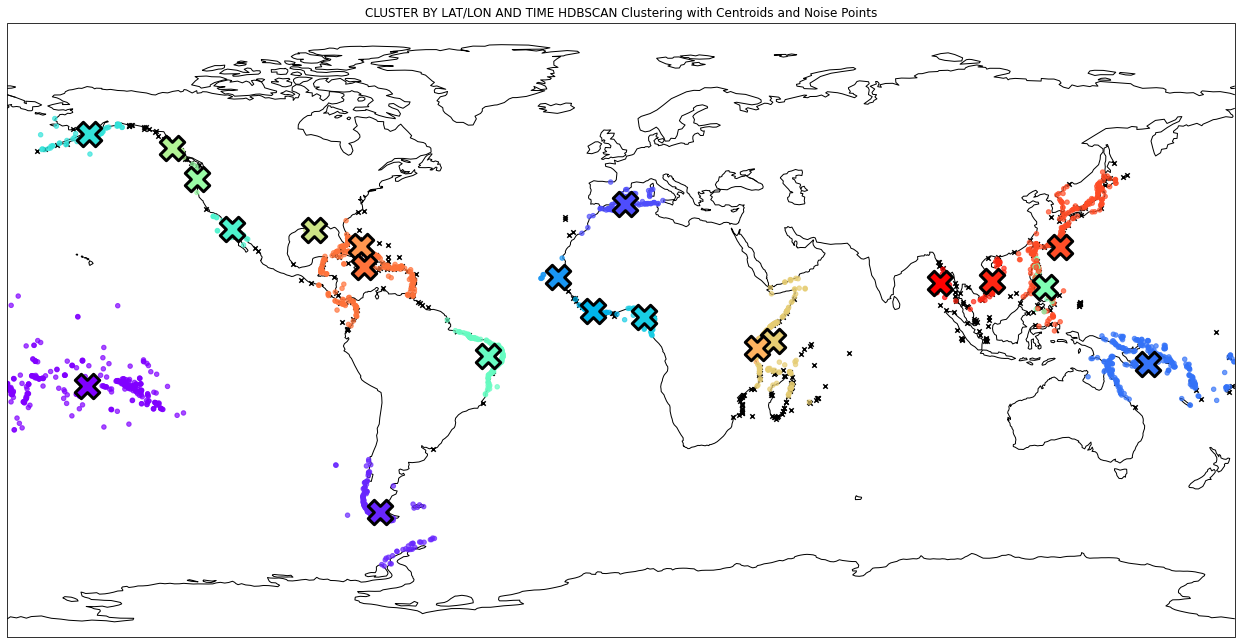

In [16]:
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

# Plot noise points as small 'x'
noise_mask = (labels == -1)
ax.scatter(cluster_input[noise_mask, 1], cluster_input[noise_mask, 0], marker='x', color='black', s=20, label='Noise Points')

# Scatter plot with colors based on HDBSCAN labels
scatter1 = plt.scatter(
    cluster_input[labels != -1, 1],
    cluster_input[labels != -1, 0],
    marker='o',
    c=labels[labels != -1],
    cmap='rainbow',
    alpha=0.7,
    s=20
)

# Plot centroids with the same colors as corresponding points
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id != -1:
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        color = scatter1.to_rgba(cluster_id)  # Get the color from the first scatter plot
        ax.scatter(centroid[1], centroid[0], marker='X', color=color, edgecolor='black', linewidths=3, s=600, label=f'Cluster {cluster_id} Centroid')

# Get the colors used in the first figure
colors_first_figure = scatter1.to_rgba(scatter1.get_array())

#ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('CLUSTER BY LAT/LON AND TIME HDBSCAN Clustering with Centroids and Noise Points')
plt.show()

In [17]:
unique_labels_figure1 = np.unique(cluster_df['HDBSCAN'])

# organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 0:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# resample without replacement
num_trajectories = round(len(beach_clusters_select)/2)
resampled_df = beach_clusters_select.sample(n=num_trajectories, replace=False, random_state=42)
resampled_df.reset_index(drop=True, inplace=True)

resampled_df = beach_clusters_select ##no replacement -----------------------------------------------------------------------------

# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), resampled_df.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(resampled_df['id'])]

# Create a colormap with distinct colors for each cluster label
colors_custom_cmap = plt.cm.get_cmap('rainbow', len(unique_labels_figure1))

# Create a dictionary to map each cluster label to its corresponding color
cluster_color_mapping = dict(zip(unique_labels_figure1, range(len(unique_labels_figure1))))

# Apply the mapping to the HDBSCAN labels in the beach_clusters DataFrame
beach_clusters['Color'] = beach_clusters['HDBSCAN'].map(cluster_color_mapping)

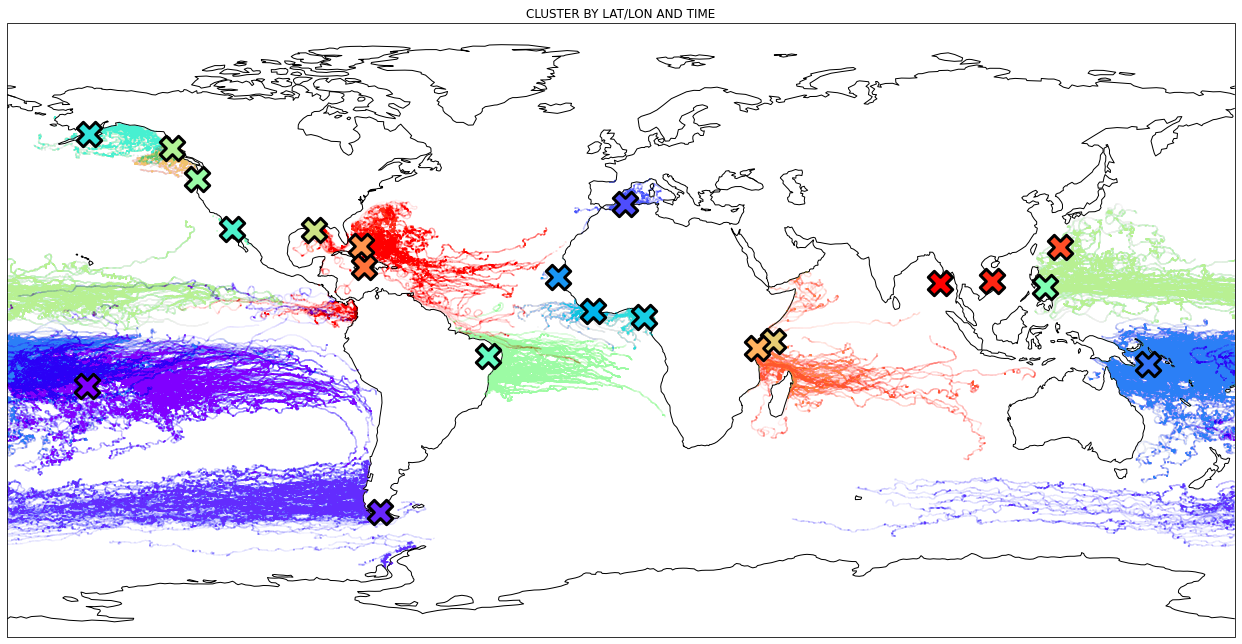

In [18]:
# Plotting code for the second figure

point_size = 0.00005

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot with colors based on the custom colormap
scatter2 = plt.scatter(
    beach_clusters['lon'],
    beach_clusters['lat'],
    marker='o',
    c=beach_clusters['Color'],
    cmap=colors_custom_cmap,
    s=point_size,
    alpha=0.7
)


# Plot centroids with the same colors as corresponding points
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id in np.unique(beach_clusters['HDBSCAN']):
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        color = scatter1.to_rgba(cluster_id)  # Get the color from the first scatter plot
        ax.scatter(centroid[1], centroid[0], marker='X', color=color, edgecolor='black', linewidths=3, s=600, label=f'Cluster {cluster_id} Centroid')


# Add colorbar
#cbar = plt.colorbar(scatter2, orientation='vertical', pad=0.02, ticks=unique_labels_figure2)
#cbar.set_label('HDBSCAN Cluster', fontsize=16)
#cbar.ax.tick_params(labelsize=14)

plt.title('CLUSTER BY LAT/LON AND TIME')

plt.show()

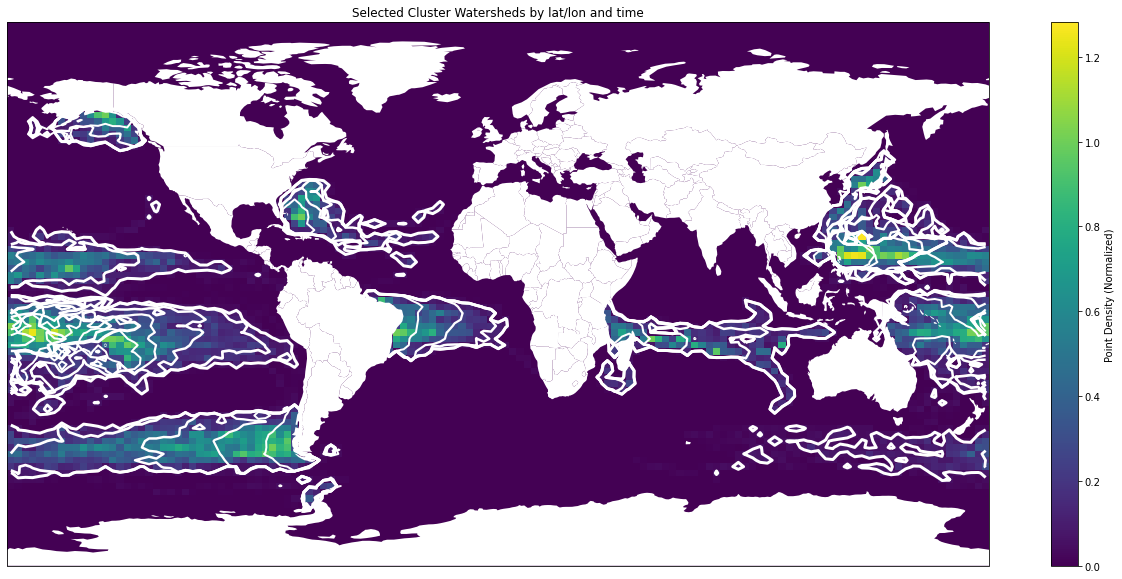

In [27]:
cluster_outputs = []
for i in np.unique(beach_clusters['HDBSCAN']):
    cluster_outputs.append(beach_clusters[beach_clusters['HDBSCAN'] == i])

selected_clusters = [cluster_outputs[i] for i in [0, 1, 3, 7, 9, 10, 15,16,18]]

fig = plt.figure(figsize=(22, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

cmap = plt.cm.get_cmap("viridis").copy()
#cmap.set_bad('grey')



###full
# Define the grid for the heatmap
n_lons, n_lats = 135, 85  # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

# initialize mesh
heatmap_data_normalized = np.zeros((n_lats, n_lons))

for cluster in selected_clusters:
    
    latitudes = []
    longitudes = []
    latitudes12 = []
    longitudes12 = []
    latitudes6 = []
    longitudes6 = []
    latitudes3 = []
    longitudes3 = []
    latitudes1 = []
    longitudes1 = []

    for ID in np.unique(cluster['id']):
        trajectory = cluster[cluster['id'] == ID]

        latest_time = max(trajectory['time'])
        start_time = latest_time - 15552000000000 # Full
        start_time12 = latest_time - 31536000 # 12m
        start_time6 = latest_time - 15552000 # 6m
        start_time3 = latest_time - 7890000 # 3m
        start_time1 = latest_time - 2629800 # 1m

        latest_data_all = trajectory[trajectory['time'] <= latest_time]

        latest_data = latest_data_all[latest_data_all['time'] >= start_time]
        latest_data12 = latest_data_all[latest_data_all['time'] >= start_time12]
        latest_data6 = latest_data_all[latest_data_all['time'] >= start_time6]
        latest_data3 = latest_data_all[latest_data_all['time'] >= start_time3]
        latest_data1 = latest_data_all[latest_data_all['time'] >= start_time1]

        latitudes += list(latest_data['lat'])
        longitudes += list(latest_data['lon'])

        latitudes12 += list(latest_data12['lat'])
        longitudes12 += list(latest_data12['lon'])

        latitudes6 += list(latest_data6['lat'])
        longitudes6 += list(latest_data6['lon'])

        latitudes3 += list(latest_data3['lat'])
        longitudes3 += list(latest_data3['lon'])

        latitudes1 += list(latest_data1['lat'])
        longitudes1 += list(latest_data1['lon'])




    # Calculate the 2D histogram (density plot) of point density
    heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized_cluster = (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

    lon_centers_cluster = (lon_bins[1:] + lon_bins[:-1]) / 2
    lat_centers_cluster = (lat_bins[1:] + lat_bins[:-1]) / 2
    
    # append to previous clusters
    heatmap_data_normalized += (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

    
    ###12

    # Calculate the 2D histogram (density plot) of point density
    heatmap_data12, _, _ = np.histogram2d(latitudes12, longitudes12, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized12 = (heatmap_data12 - np.min(heatmap_data12)) / (np.max(heatmap_data12) - np.min(heatmap_data12))

    ###6

    # Calculate the 2D histogram (density plot) of point density
    heatmap_data6, _, _ = np.histogram2d(latitudes6, longitudes6, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized6 = (heatmap_data6 - np.min(heatmap_data6)) / (np.max(heatmap_data6) - np.min(heatmap_data6))

    ###3

    # Calculate the 2D histogram (density plot) of point density
    heatmap_data3, _, _ = np.histogram2d(latitudes3, longitudes3, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized3 = (heatmap_data3 - np.min(heatmap_data3)) / (np.max(heatmap_data3) - np.min(heatmap_data3))


    ###1

    # Calculate the 2D histogram (density plot) of point density
    heatmap_data1, _, _ = np.histogram2d(latitudes1, longitudes1, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized1 = (heatmap_data1 - np.min(heatmap_data1)) / (np.max(heatmap_data1) - np.min(heatmap_data1))


    # Repeat the process for other plots with increasing linewidth
    linewidths = [3, 2.75, 2.5, 2.25, 2]
    for data_normalized, linewidth in zip([heatmap_data_normalized_cluster, heatmap_data_normalized12, heatmap_data_normalized6, heatmap_data_normalized3, heatmap_data_normalized1], linewidths):
        # Add contour lines at the specified level (0.05 in this case)
        contour = plt.contour(lon_centers_cluster, lat_centers_cluster, data_normalized, levels=[0.05], colors='white', linestyles='solid', linewidths=linewidth, transform=ccrs.PlateCarree())
    
# Plot the filled contour for normalized heatmap
mesh = ax.pcolormesh(lon_centers_cluster, lat_centers_cluster, heatmap_data_normalized, cmap=cmap, transform=ccrs.PlateCarree())

# Plot the land polygons with white face color, no edge
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(mesh, label='Point Density (Normalized)')
ax.set_aspect('auto')
plt.title('Selected Cluster Watersheds by lat/lon and time')



plt.show()

# -------------------------------------------------

In [29]:
# get features for clustering and normalize to close to scale of lat/lon with lat/lon weighted for clustering AND RUN HDBSCAN TWICE

# input feature: average velocity of trajectory
v_avg_data = np.array(beach.groupby('id')['speed'].mean()).reshape(-1,1) # get average velocity for each trajectory
v_avg_scaler = MinMaxScaler(feature_range=(0, 10)) # normalization scale
v_avg_normalized = v_avg_scaler.fit_transform(v_avg_data).flatten() # normalize

# input feature: total time to beach
first_points_input = beach.drop_duplicates(subset='id', keep='first') # get furthest points from beaching

time_data = np.array(first_points_input['time_to_beach']).reshape(-1, 1) # get trajectory time to beach
time_scaler = MinMaxScaler(feature_range=(0, 90)) # normalization scale
time_normalized = time_scaler.fit_transform(time_data).flatten() # normalize

# get beach points for beach lat/lon
last_points_input = beach.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon, time_normalized, v_avg_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 30, # minimum number beach points in a cluster
    cluster_selection_epsilon = 6) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

#organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 100:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), beach_clusters_select.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(beach_clusters_select['id'])]

In [30]:
# NOW INPUT CLUSTERED DATA INTO NEW HDBSCAN

# input feature: average velocity of trajectory
v_avg_data = np.array(beach_clusters.groupby('id')['speed'].mean()).reshape(-1,1) # get average velocity for each trajectory
v_avg_scaler = MinMaxScaler(feature_range=(0, 10)) # normalization scale
v_avg_normalized = v_avg_scaler.fit_transform(v_avg_data).flatten() # normalize

# input feature: total time to beach
first_points_input = beach_clusters.drop_duplicates(subset='id', keep='first') # get furthest points from beaching

time_data = np.array(first_points_input['time_to_beach']).reshape(-1, 1) # get trajectory time to beach
time_scaler = MinMaxScaler(feature_range=(0, 90)) # normalization scale
time_normalized = time_scaler.fit_transform(time_data).flatten() # normalize

# get beach points for beach lat/lon
last_points_input = beach_clusters.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon, time_normalized, v_avg_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 10, # minimum number beach points in a cluster
    cluster_selection_epsilon = 5) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

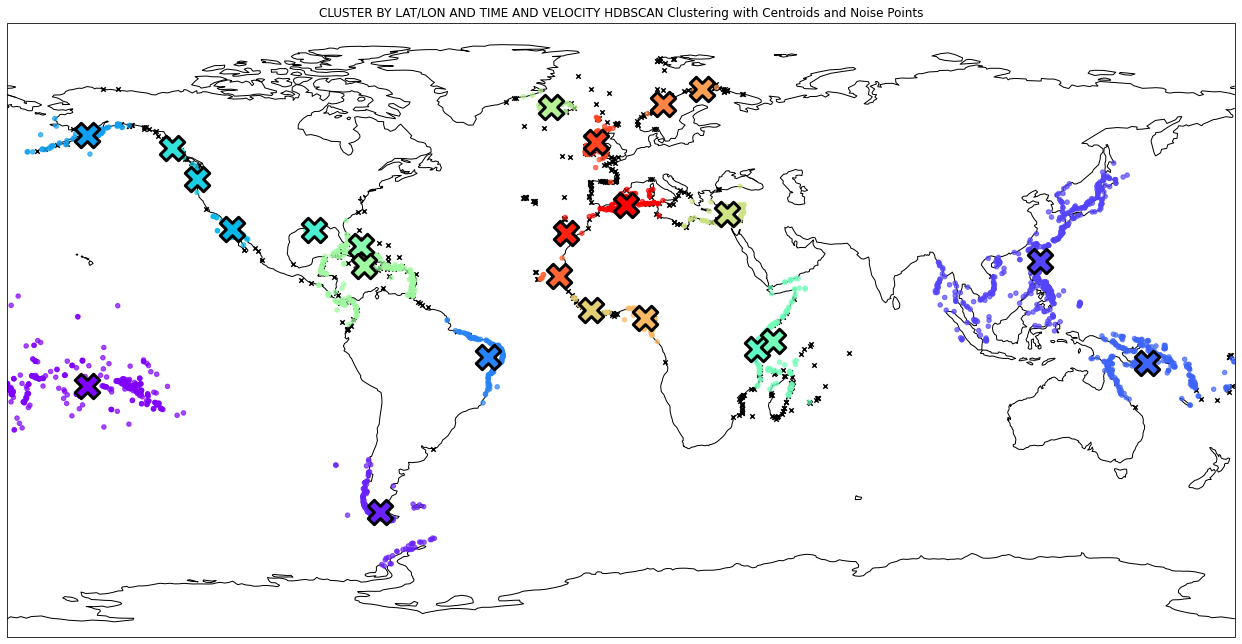

In [31]:
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

# Plot noise points as small 'x'
noise_mask = (labels == -1)
ax.scatter(cluster_input[noise_mask, 1], cluster_input[noise_mask, 0], marker='x', color='black', s=20, label='Noise Points')

# Scatter plot with colors based on HDBSCAN labels
scatter1 = plt.scatter(
    cluster_input[labels != -1, 1],
    cluster_input[labels != -1, 0],
    marker='o',
    c=labels[labels != -1],
    cmap='rainbow',
    alpha=0.7,
    s=20
)

# Plot centroids with the same colors as corresponding points
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id != -1:
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        color = scatter1.to_rgba(cluster_id)  # Get the color from the first scatter plot
        ax.scatter(centroid[1], centroid[0], marker='X', color=color, edgecolor='black', linewidths=3, s=600, label=f'Cluster {cluster_id} Centroid')

# Get the colors used in the first figure
colors_first_figure = scatter1.to_rgba(scatter1.get_array())

#ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('CLUSTER BY LAT/LON AND TIME AND VELOCITY HDBSCAN Clustering with Centroids and Noise Points')
plt.show()

In [32]:
unique_labels_figure1 = np.unique(cluster_df['HDBSCAN'])

# organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 0:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# resample without replacement
num_trajectories = round(len(beach_clusters_select)/2)
resampled_df = beach_clusters_select.sample(n=num_trajectories, replace=False, random_state=42)
resampled_df.reset_index(drop=True, inplace=True)

resampled_df = beach_clusters_select ##no replacement -----------------------------------------------------------------------------

# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), resampled_df.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(resampled_df['id'])]

# Create a colormap with distinct colors for each cluster label
colors_custom_cmap = plt.cm.get_cmap('rainbow', len(unique_labels_figure1))

# Create a dictionary to map each cluster label to its corresponding color
cluster_color_mapping = dict(zip(unique_labels_figure1, range(len(unique_labels_figure1))))

# Apply the mapping to the HDBSCAN labels in the beach_clusters DataFrame
beach_clusters['Color'] = beach_clusters['HDBSCAN'].map(cluster_color_mapping)

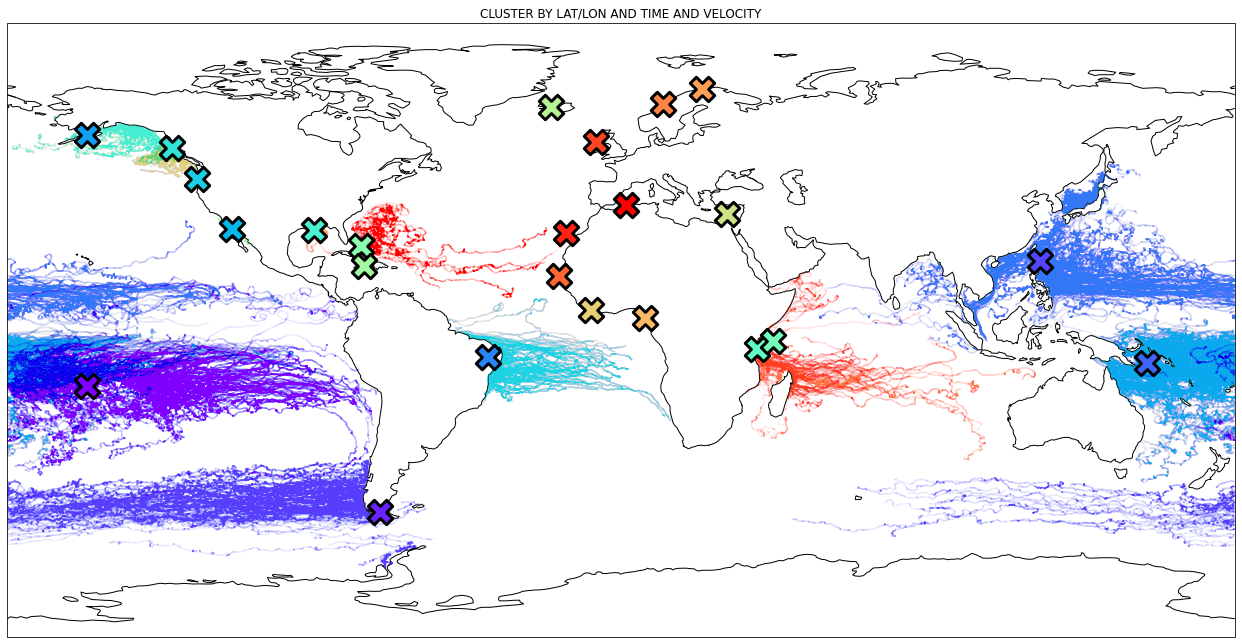

In [33]:
# Plotting code for the second figure

point_size = 0.00005

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot with colors based on the custom colormap
scatter2 = plt.scatter(
    beach_clusters['lon'],
    beach_clusters['lat'],
    marker='o',
    c=beach_clusters['Color'],
    cmap=colors_custom_cmap,
    s=point_size,
    alpha=0.7
)


# Plot centroids with the same colors as corresponding points
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id in np.unique(beach_clusters['HDBSCAN']):
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        color = scatter1.to_rgba(cluster_id)  # Get the color from the first scatter plot
        ax.scatter(centroid[1], centroid[0], marker='X', color=color, edgecolor='black', linewidths=3, s=600, label=f'Cluster {cluster_id} Centroid')


# Add colorbar
#cbar = plt.colorbar(scatter2, orientation='vertical', pad=0.02, ticks=unique_labels_figure2)
#cbar.set_label('HDBSCAN Cluster', fontsize=16)
#cbar.ax.tick_params(labelsize=14)

plt.title('CLUSTER BY LAT/LON AND TIME AND VELOCITY')

plt.show()

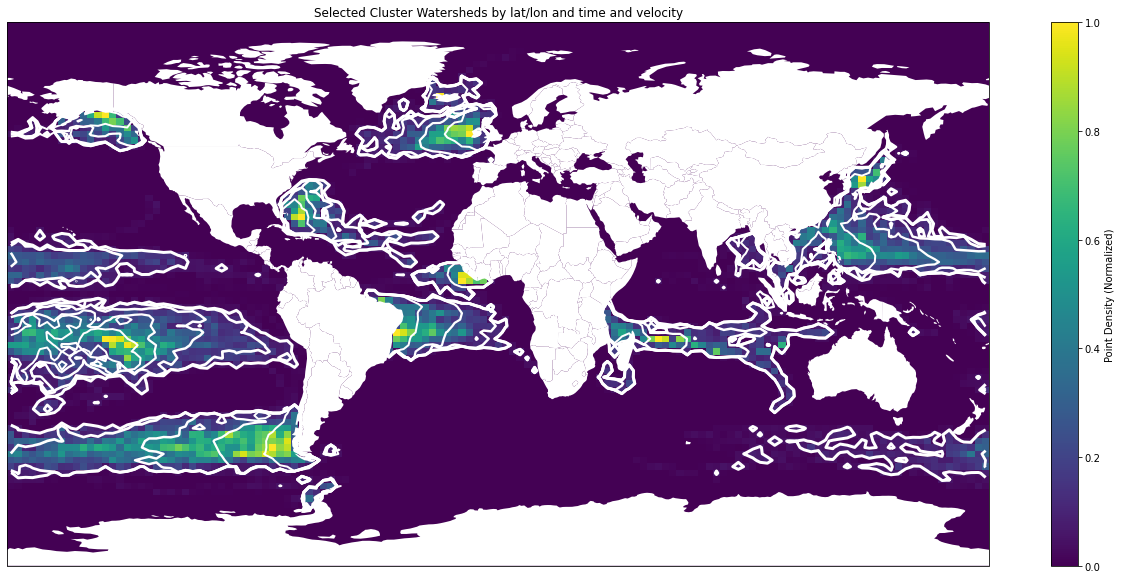

In [37]:
cluster_outputs = []
for i in np.unique(beach_clusters['HDBSCAN']):
    cluster_outputs.append(beach_clusters[beach_clusters['HDBSCAN'] == i])

selected_clusters = [cluster_outputs[i] for i in [0, 1, 2, 4, 5, 10, 12, 14, 16, 21]]

fig = plt.figure(figsize=(22, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

cmap = plt.cm.get_cmap("viridis").copy()
#cmap.set_bad('grey')



###full
# Define the grid for the heatmap
n_lons, n_lats = 135, 85  # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

# initialize mesh
heatmap_data_normalized = np.zeros((n_lats, n_lons))

for cluster in selected_clusters:
    
    latitudes = []
    longitudes = []
    latitudes12 = []
    longitudes12 = []
    latitudes6 = []
    longitudes6 = []
    latitudes3 = []
    longitudes3 = []
    latitudes1 = []
    longitudes1 = []

    for ID in np.unique(cluster['id']):
        trajectory = cluster[cluster['id'] == ID]

        latest_time = max(trajectory['time'])
        start_time = latest_time - 15552000000000 # Full
        start_time12 = latest_time - 31536000 # 12m
        start_time6 = latest_time - 15552000 # 6m
        start_time3 = latest_time - 7890000 # 3m
        start_time1 = latest_time - 2629800 # 1m

        latest_data_all = trajectory[trajectory['time'] <= latest_time]

        latest_data = latest_data_all[latest_data_all['time'] >= start_time]
        latest_data12 = latest_data_all[latest_data_all['time'] >= start_time12]
        latest_data6 = latest_data_all[latest_data_all['time'] >= start_time6]
        latest_data3 = latest_data_all[latest_data_all['time'] >= start_time3]
        latest_data1 = latest_data_all[latest_data_all['time'] >= start_time1]

        latitudes += list(latest_data['lat'])
        longitudes += list(latest_data['lon'])

        latitudes12 += list(latest_data12['lat'])
        longitudes12 += list(latest_data12['lon'])

        latitudes6 += list(latest_data6['lat'])
        longitudes6 += list(latest_data6['lon'])

        latitudes3 += list(latest_data3['lat'])
        longitudes3 += list(latest_data3['lon'])

        latitudes1 += list(latest_data1['lat'])
        longitudes1 += list(latest_data1['lon'])




    # Calculate the 2D histogram (density plot) of point density
    heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized_cluster = (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

    lon_centers_cluster = (lon_bins[1:] + lon_bins[:-1]) / 2
    lat_centers_cluster = (lat_bins[1:] + lat_bins[:-1]) / 2
    
    # append to previous clusters
    heatmap_data_normalized += (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

    
    ###12

    # Calculate the 2D histogram (density plot) of point density
    heatmap_data12, _, _ = np.histogram2d(latitudes12, longitudes12, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized12 = (heatmap_data12 - np.min(heatmap_data12)) / (np.max(heatmap_data12) - np.min(heatmap_data12))

    ###6

    # Calculate the 2D histogram (density plot) of point density
    heatmap_data6, _, _ = np.histogram2d(latitudes6, longitudes6, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized6 = (heatmap_data6 - np.min(heatmap_data6)) / (np.max(heatmap_data6) - np.min(heatmap_data6))

    ###3

    # Calculate the 2D histogram (density plot) of point density
    heatmap_data3, _, _ = np.histogram2d(latitudes3, longitudes3, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized3 = (heatmap_data3 - np.min(heatmap_data3)) / (np.max(heatmap_data3) - np.min(heatmap_data3))


    ###1

    # Calculate the 2D histogram (density plot) of point density
    heatmap_data1, _, _ = np.histogram2d(latitudes1, longitudes1, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized1 = (heatmap_data1 - np.min(heatmap_data1)) / (np.max(heatmap_data1) - np.min(heatmap_data1))


    # Repeat the process for other plots with increasing linewidth
    linewidths = [3, 2.75, 2.5, 2.25, 2]
    for data_normalized, linewidth in zip([heatmap_data_normalized_cluster, heatmap_data_normalized12, heatmap_data_normalized6, heatmap_data_normalized3, heatmap_data_normalized1], linewidths):
        # Add contour lines at the specified level (0.05 in this case)
        contour = plt.contour(lon_centers_cluster, lat_centers_cluster, data_normalized, levels=[0.05], colors='white', linestyles='solid', linewidths=linewidth, transform=ccrs.PlateCarree())
    
# Plot the filled contour for normalized heatmap
mesh = ax.pcolormesh(lon_centers_cluster, lat_centers_cluster, heatmap_data_normalized, cmap=cmap, transform=ccrs.PlateCarree())

# Plot the land polygons with white face color, no edge
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(mesh, label='Point Density (Normalized)')
ax.set_aspect('auto')
plt.title('Selected Cluster Watersheds by lat/lon and time and velocity')



plt.show()